In [1]:
%matplotlib inline

def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()


animation.Animation._repr_html_ = anim_to_html

NameError: name 'animation' is not defined

In [8]:
class Map():
    def __init__(self, size=100):
        self.time = 0
        if type(size) is int:
            self.size = (size, size)
        else:
            self.size = size
        rows_cols=[self.size[0]/10, self.size[1]/10]
        
        self.groups = {
            'Grass': Group(dim=self.size, rows_cols=rows_cols),
            'Water': Group(dim=self.size, rows_cols=rows_cols)
        }
        
        self.groups['Grass'].delete_at_0 = True
        
        self.pop = Population(dim=self.size, rows_cols=rows_cols)
        
        self.colors = {
            'Grass':'g', 
            'Water':'b',
            'Animals': 'r'
        }
        self.autopop={
            'Animals':None,
            'Grass':None, 
            'Water':None
        }
        self.memory = MapMemory(self)
        
        
    def fill_groups(self, n, v=0):
        if type(n) is int:
            n = [n for _ in range(len(self.groups))]
        if type(v) is int:
            v = [v for _ in range(len(self.groups))]
        i = 0
        for k in self.groups:
            self.groups[k].fill(n=n[i], value=v[i])
            i +=1
        return self
        
    def update_map(self, verbose = False):
        if verbose: print("Time", self.time)
        self.get_autopop()
        self.pop.update_pos()
        if MAP_CONFIG['Season_time'] is not None:
            fix = MAP_CONFIG['Grass_growth'] * cos( 2 * pi * self.time / MAP_CONFIG['Season_time'])
        else:
            fix = MAP_CONFIG['Grass_growth']
        self.groups['Grass'].update_values(fix= fix, random=True, do_if_neg=True)
        
        # Animal on food
        l = self.pop.collision(distance=MAP_CONFIG['Food_distance'] , other=self.groups['Grass'])
        if l is not None:
            for a, b, n_a, n_b  in l:
                if a is not None and b is not None:
                    if verbose : print('Food', a, '/', b)
                    if b >0 and a.stamina < a.get_carac('Max_stamina'):
                        eaten = min(b, MAP_CONFIG['Max_food'])
                        a.eat_grass(eaten*5)
                        self.groups['Grass'].change_value(n_b, new_value= b - eaten)
        
        # Animal collisions
        babies = []
        l = self.pop.collision(distance=MAP_CONFIG['Mate_distance'] )
        if l is not None:
            for a, b, n_a, n_b in l:
                if a is not None:
                    if verbose : print('Collide', a, '/', b)
                    a_i = a.interact(b)
                    b_i = b.interact(a)
                    if a_i == 'Mate' and b_i == 'Mate' and rd.random()<0.5:
                        new = a + b
                        babies.append(new)
                        #print('Mating :', a, '||', b)
                        #print("New", new)
                        
        for new in babies:
            if new is not None: self.pop.add_point(new.cin.x, new.cin.y, new)
        
        self.pop.clean_dead()
        
        self.time += 1
        return self
    
    def plot(self):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        for g in self.groups:
            x, y, v = self.groups[g].plot(display=False)
            if len(x) > 0: ax.scatter(x, y, s=v, c=self.colors[g])
        d = self.pop.plot(display=False)
        if len(d) > 0:
            Q = ax.quiver(d[:, 0], d[:, 1], np.cos(d[:, 2]), np.sin(d[:, 2]), pivot='mid', color=self.colors['Animals'], scale = 50)
        return self
    
    def set_autopop(self, target, n, period=100, value=None):
        self.autopop[target]=(n, period, value)
        return self
        
    def get_autopop(self):
        for i in self.autopop:
            if self.autopop[i] is not None and not self.time % self.autopop[i][1]:
                if i == 'Animals':
                    self.pop.fill(n=self.autopop[i][0])
                elif i =='Grass':
                    m.fill_groups(n=[self.autopop[i][0], 0], v=self.autopop[i][2])
                elif i =='Water':
                    m.fill_groups(n=[0, self.autopop[i][0]], v=self.autopop[i][2])
    
    def animate(self, steps = 100, interval = 100):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_axes([0, 0, 1, 1], frameon=True, aspect=1)
        ax.set_xlim(0, self.size[0])
        ax.set_ylim(0, self.size[1])
              
        # Grass
        x, y, v = self.groups['Grass'].plot(display=False)
        if len(x) != 0 :
            G = ax.scatter(x, y, s=v, c=self.colors['Grass'])
        else:
            G = ax.scatter([], [], s=v, c=self.colors['Grass'])
        
        # Water
        x, y, v = self.groups['Water'].plot(display=False)
        if len(x) != 0 :
            W = ax.scatter(x, y, s=-1 * np.array(v), c=self.colors['Water'])
        else:
            W = ax.scatter([], [], s=-1 * np.array(v), c=self.colors['Water'])
            
         # Population
        d = self.pop.plot(display=False)
        if len(d) > 0:
            P = ax.quiver(d[:, 0], d[:, 1], np.cos(d[:, 2]), np.sin(d[:, 2]), pivot='mid', color=self.colors['Animals'], scale = 50)
        else:
            P = ax.quiver([], [], [], [], pivot='mid', color=self.colors['Animals'], scale = 50)


        def update(frame):
            print(str(frame + 1) + '/' + str(steps) + ' | ' + str(len(self.pop)) + '     ', end='\r')
            self.update_map(verbose = False)
            
            #Population
            d = self.pop.plot(display=False)
            if len(d)>0:
                P.set_UVC(np.cos(d[:, 2]), np.sin(d[:, 2]))
                P.set_offsets(np.c_[d[:, 0], d[:, 1]])
            
            # Grass
            x, y, v = self.groups['Grass'].plot(display=False)
            if len(x) > 0 : G.set_sizes(v)
            self.memory.update()
            return P, G, W
        

        
        return animation.FuncAnimation(fig, update, steps, interval=interval, blit=False, repeat=False)
        
    

In [42]:
SIZE = (16, 8)
class MapMemory():
    def __init__(self, _map):
        self.map=_map
        self.pop_size = []
        self.brain_genes = []
        self.brain_size = []
        
        self.tracking={}
        for n in TRACKING:
            self.tracking[n] = []
        
    def update(self):
        self.pop_size.append(len(self.map.pop))
        
        ### Brain
        # Gene distribution
        genes=[]
        for n, p in self.map.pop.unroll():
            for g in p.brain.genome:
                genes.append(g.innov)
        self.brain_genes.append(genes)
        
        # Number of genes
        gene_num=[]
        for n, p in self.map.pop.unroll():
            gene_num.append(len(p.brain))
        self.brain_size.append(gene_num)
        
        # Tracking animal stats
        new_track = {}
        for n in TRACKING:
            new_track[n] = []
            
        for n, p in self.map.pop.unroll():
            for t in TRACKING:
                new_track[t].append(p.get_carac(t))
        
        for t in TRACKING:
            self.tracking[t].append(new_track[t])
        
        
    def evol_scatter(self, data, xlabel='Frames', ylabel='', title=''):
        try:
            m = np.max(data)
        except:
            return -1
        fig = plt.figure(figsize=SIZE)
        N = len(data)
        ind = np.arange(N)

        vmax=0
        
        for i in ind:
            d = data[i]
            unique, counts = np.unique(d, return_counts=True)
            if len(d) !=0: 
                sc=plt.scatter(np.full(len(unique), i), unique, c=counts, s=10)
                sc.set_clim(0.0, max(counts))
        
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('Number of animals', rotation=270)
        cbar.ax.get_yaxis().labelpad = 15
        
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()
        
    def plot(self, data, xlabel='Frames', ylabel='', title=''):
        fig = plt.figure(figsize=SIZE)
        plt.plot(data)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)   
        plt.title(title)
        plt.show()
        
    def scatter(self, data, xlabel='Frames', ylabel='', title=''):
        quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        data_q = {}

        for q in quantiles:
            data_q[q]=[]
            
        for i in range(len(data)):
            d_t = data[i]
            for q in quantiles:
                data_q[q].append(np.quantile(d_t, q))

        x = np.arange(len(d))
        plt.figure(figsize=(16, 8))
        
        for q in np.flip(quantiles[1:]):
            plt.fill_between(x, data_q[0], data_q[q])

        plt.legend(np.flip(quantiles[1:]), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()
        
    def analysis(self):     
        self.plot(self.pop_size, ylabel='Population size', title='Evolution of population size')
        self.evol_scatter(self.brain_size, 'Frames', 'Number of genes', title='Evolution of brain size')
        self.evol_scatter(self.brain_genes, 'Frames', 'Gene IDs', title='Evolution of brain genes distribution')
        #for t in TRACKING:
        #    self.scatter(self.tracking[t], ylabel='value', title='Evolution of ' + t)
        
        


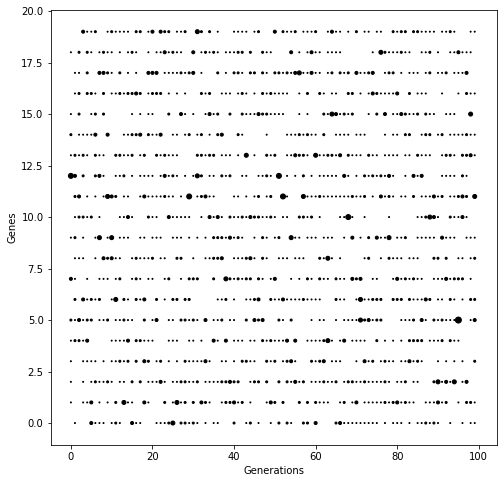

In [41]:
import numpy as np
import matplotlib.pyplot as plt
data= np.random.randint(20, size=(100, 20))

